# Technical challenge

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Part 1

In [2]:
df=pd.read_csv('/Users/juliaromagosa/Downloads/part1_inventory_test.csv')
df.head()

<ipython-input-2-62e428f88536>:1: DtypeWarning: Columns (129,138,139,140,141,142,143,148,152,157,158,168,169,172,173,176,179,180,181,189,191) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/Users/juliaromagosa/Downloads/part1_inventory_test.csv')


,PatientID,PatientSex,PatientBirthDate,StudyInstanceUID,StudyDescription,StudyDate,SeriesInstanceUID,SeriesDescription,Manufacturer,Instances,...,RETIRED_CurveDimensions,RETIRED_NumberOfPoints,RETIRED_TypeOfData,RETIRED_CurveDescription,RETIRED_DataValueRepresentation,RETIRED_CurveData,SmallestPixelValueInSeries,LargestPixelValueInSeries,ScanArc,RouteOfAdmissions
0,K100,NaN,NaN,1.3.12.2.1107.5.1.4.28600023236596336688906318...,CT BRAIN WO CONTRAST (70450),20220401,1.3.12.2.1107.5.1.4.19743776053189314668198005...,Topogram__0_6__T20s,SIEMENS,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,K100,NaN,NaN,1.3.12.2.1107.5.1.4.28600023236596336688906318...,CT BRAIN WO CONTRAST (70450),20220401,1.3.12.2.1107.5.1.4.14463949905640131236256856...,Helical_Head__5_0__J37s,SIEMENS,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,K100,NaN,NaN,1.3.12.2.1107.5.1.4.28600023236596336688906318...,CT BRAIN WO CONTRAST (70450),20220401,1.3.12.2.1107.5.1.4.11270577611930653926640724...,Helical_Head__5_0__Axial_MPR,SIEMENS,41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,K100,NaN,NaN,1.3.12.2.1107.5.1.4.28600023236596336688906318...,CT BRAIN WO CONTRAST (70450),20220401,1.3.12.2.1107.5.1.4.17407020384920076295523451...,Helical_Head_Coronal,SIEMENS,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,K100,NaN,NaN,1.3.12.2.1107.5.1.4.28600023236596336688906318...,CT BRAIN WO CONTRAST (70450),20220401,1.3.12.2.1107.5.1.4.84337701080239475497944344...,Helical_Head_Sagittal,SIEMENS,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# check the number of patients
n_patients=df['PatientID'].nunique()
print(f'Number of patients: {n_patients}')

Number of patients: 326


The conditions which have to be met are:
- Non-contrast image
- CT modality
- Axial orientation
- Slice thickness between 2.5 and 5 mm’s
- First (in time) NCCT acquired.

In [4]:
# First we select only CT images
df=df[df.Modality=='CT']
# See different types of studies
set(df.StudyDescription.values)

{'CT ANGIO HEAD & NECK W/WO (70496, 70498)',
 'CT ANGIO HEAD W/WO CONTRAST (70496)',
 'CT BRAIN WO CONTRAST (70450)',
 'CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
 'CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
 'EXTERNAL CT - STORE ONLY',
 'EXTERNAL CT - STORE ONLY - RAD',
 'EXTERNAL CT BRAIN - STORE ONLY',
 'EXTERNAL CT BRAIN - STORE ONLY - RAD',
 'EXTERNAL CT BRAIN INTERPRET',
 'EXTERNAL CT-STORE & INTERPRET',
 'EXTERNAL CTA HEAD - STORE ONLY',
 'EXTERNAL CTA HEAD - STORE ONLY - RAD',
 'EXTERNAL CTA HEAD INTERPRET'}

As many are ambiguous, we observe the values of the contrast columns:

In [5]:
contrast_columns = [column for column in df.columns if 'Contrast' in column]

# Count NaN 
contrast_nan = df[contrast_columns].notna().sum()

print(contrast_nan)

ContrastBolusAgent                        0
ContrastBolusVolume                     162
ContrastBolusTotalDose                  162
ContrastBolusIngredient                   0
ContrastBolusIngredientConcentration    162
ContrastBolusStartTime                  223
ContrastBolusStopTime                   158
ContrastFlowRate                        159
ContrastFlowDuration                    159
ContrastBolusRoute                        0
dtype: int64


As there are values which are not nan, we observe if them are 0 or otherwise they do have an information about the contrast, meaning there is information about the contrast agent.

In [6]:
# See which values are different from nan in the column more restrictive
valores_no_nan = df['ContrastBolusStartTime'].dropna()
valores_no_nan.unique()

array([124130.442014, 133126.302006, 221902.394997, 182357.054004,
       161141.108998,  51332.058011, 203222.684025, 211833.      ,
       122116.39702 , 142155.31201 , 135009.152001,  45254.952993,
       154423.735019, 184904.52903 , 134205.483009, 171601.85    ,
       172655.85    , 121619.4     ,  63924.330004,  93247.119002,
       163453.84902 , 123126.060017, 212805.55    , 102619.75    ,
        60050.078988, 103518.75    , 141403.757014, 103304.961016])

As they are not 0 and not nan, it is supposed that this images are acquired with contrast.

In [7]:
# Select only nan columns, so it means there is no contrast
df_cleaned = df[df['ContrastBolusStartTime'].isna()]

Now we have cleaned images with contrast and selected CT images.

To select only axial images we look for the orientation and select '1\\0\\0\\0\\1\\0' rows:

In [8]:
#for axial images
df_cleaned.ImageOrientationPatient.values

array(['0\\1\\0\\0\\0\\-1', '1\\0\\0\\0\\1\\0',
       '0.99722881968274\\-0.074395437993\\0\\0.05887243050198\\0.78915167334069\\-0.6113703242638',
       ..., nan, '1\\-6.123234e-017\\0\\0\\0\\-1',
       '1\\-6.123234e-017\\0\\0\\0\\-1'], dtype=object)

As many don't are excat, we round the numbers:

In [9]:
#drop nan values form this column
df_cleaned=df_cleaned.dropna(subset=['ImageOrientationPatient'])
df_cleaned.reset_index(inplace=True,drop=True)

# Round values
for index in range(len(df_cleaned)):
    parts = df_cleaned.loc[index, 'ImageOrientationPatient'].split('\\')
    rounded_parts = [str(int(round(float(part)))) for part in parts]
    df_cleaned.loc[index, 'ImageOrientationPatient'] = '\\'.join(rounded_parts)

df_cleaned.ImageOrientationPatient.values

array(['0\\1\\0\\0\\0\\-1', '1\\0\\0\\0\\1\\0', '1\\0\\0\\0\\1\\-1', ...,
       '0\\1\\0\\0\\0\\-1', '1\\0\\0\\0\\0\\-1', '1\\0\\0\\0\\0\\-1'],
      dtype=object)

In [10]:
# Select only Axial images
df_cleaned=df_cleaned[df_cleaned['ImageOrientationPatient']=='1\\0\\0\\0\\1\\0']

For the slice thickness condition:

In [11]:
# Slice thickness between 2.5 and 5 mm’s
# first drop nan
df_cleaned=df_cleaned.dropna(subset=['SliceThickness'])
df_cleaned.SliceThickness.values

# Select appropiate thickness
df_cleaned = df_cleaned[(df_cleaned['SliceThickness'] >= 2.5) & (df_cleaned['SliceThickness'] <= 5)]

Now, I check BodyPartExamined of the remaining:

In [12]:
set(df_cleaned.BodyPartExamined.values)

{'BRAIN', 'CT_ HEAD', 'CT_HEAD', 'HEAD', 'NECK', nan}

In [13]:
# clean the neck image to ensure all are brain images
df = df_cleaned[df_cleaned['BodyPartExamined'] != 'NECK']

In [14]:
# check the number of patients is still the same
n_patients=df['PatientID'].nunique()
print(f'Number of patients: {n_patients}')

Number of patients: 323


Now, I check ImageType of the remaining:

In [15]:
set(df.ImageType.values)

{'DERIVED\\PRIMARY\\AXIAL\\CT_SOM5 MPR',
 'DERIVED\\PRIMARY\\LOCALIZER\\CT_SOM5 MPR',
 'DERIVED\\PRIMARY\\MPR',
 'DERIVED\\SECONDARY\\AXIAL',
 'DERIVED\\SECONDARY\\AXIAL\\MIP THIN\\\\\\PARALLEL',
 'DERIVED\\SECONDARY\\AXIAL\\MPR THICK\\\\\\PARALLEL',
 'DERIVED\\SECONDARY\\MPR',
 'DERIVED\\SECONDARY\\OTHER',
 'DERIVED\\SECONDARY\\OTHER\\CSA MIP THIN\\\\AXIAL\\CT_SOM5 SPI',
 'DERIVED\\SECONDARY\\OTHER\\CSA MIP THIN\\\\AXIAL\\CT_SOM5 SPI\\CSA RESAMPLED',
 'DERIVED\\SECONDARY\\OTHER\\CSA MPR THICK\\\\AXIAL\\CT_SOM5 SPI',
 'ORIGINAL\\PRIMARY\\AXIAL',
 'ORIGINAL\\PRIMARY\\AXIAL\\CT_SOM5 SPI',
 'ORIGINAL\\PRIMARY\\AXIAL\\VOLUME'}

In this case I'd need more information in the type of images which are used for the algorithm training, as if MIP or MPR can be used or just the original CT file.

In [16]:
# I'd delete the localizer image and the volume one
delete = ['DERIVED\\PRIMARY\\LOCALIZER\\CT_SOM5 MPR', 'ORIGINAL\\PRIMARY\\AXIAL\\VOLUME']
df_filtered = df[~df['ImageType'].isin(delete)]

In [17]:
# check the number of patients
n_patients=df_filtered['PatientID'].nunique()
print(f'Number of patients: {n_patients}')

Number of patients: 323


Now to obtain the first image in date:

In [18]:
# Convert 'StudyDate' to datetime format
df_filtered['StudyDate'] = pd.to_datetime(df_filtered['StudyDate'], format='%Y%m%d')

# Sort by 'PatientID' and 'StudyDate'
df_sorted = df_filtered.sort_values(by=['PatientID','StudyDate'])

# Drop duplicates to get the first 'StudyDate'
df = df_sorted.drop_duplicates(subset='PatientID', keep='first')

df

<ipython-input-18-faf0cfbbf491>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['StudyDate'] = pd.to_datetime(df_filtered['StudyDate'], format='%Y%m%d')


,PatientID,PatientSex,PatientBirthDate,StudyInstanceUID,StudyDescription,StudyDate,SeriesInstanceUID,SeriesDescription,Manufacturer,Instances,...,RETIRED_CurveDimensions,RETIRED_NumberOfPoints,RETIRED_TypeOfData,RETIRED_CurveDescription,RETIRED_DataValueRepresentation,RETIRED_CurveData,SmallestPixelValueInSeries,LargestPixelValueInSeries,ScanArc,RouteOfAdmissions
1692,B1,NaN,NaN,1.3.12.2.1107.5.1.4.14405302048733134033500556...,CT BRAIN WO CONTRAST (70450),2021-08-26,1.3.12.2.1107.5.1.4.30448595353741225300805509...,Helical_Head_5_0_H41s,SIEMENS,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1522,B10,NaN,NaN,1.3.12.2.1107.5.1.4.29464022356853068835595950...,CT BRAIN WO CONTRAST (70450),2021-08-26,1.3.12.2.1107.5.1.4.20640263391473193003119895...,Head__5_0__H41s,SIEMENS,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529,B11,NaN,NaN,1.3.12.2.1107.5.1.4.70920213018646500067184273...,CT BRAIN WO CONTRAST (70450),2021-08-26,1.3.12.2.1107.5.1.4.15768733593244333268036332...,Head__5_0__J37s__1,SIEMENS,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1574,B12,NaN,NaN,1.3.12.2.1107.5.1.4.88283879956991102502385177...,CT BRAIN WO CONTRAST (70450),2021-08-26,1.3.12.2.1107.5.1.4.27610016466863260409541068...,Helical_Head_5_0_H41s,SIEMENS,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1587,B16,NaN,NaN,1.3.12.2.1107.5.1.4.13870762043879883155821812...,CT BRAIN WO CONTRAST (70450),2021-08-26,1.3.12.2.1107.5.1.4.62898310134561535724386666...,Head__5_0__H41s,SIEMENS,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,X95,NaN,NaN,1.3.12.2.1107.5.1.4.26319050177286294006301705...,CT BRAIN WO CONTRAST (70450),2022-04-08,1.3.12.2.1107.5.1.4.27907423437829554333475568...,Head__5_0__J37s__1,SIEMENS,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1487,X96,NaN,NaN,1.3.12.2.1107.5.1.4.12507122691666544533153812...,CT BRAIN WO CONTRAST (70450),2022-04-08,1.3.12.2.1107.5.1.4.29888479019532550615118662...,Head__5_0__J37s__1,SIEMENS,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1494,X97,NaN,NaN,1.3.12.2.1107.5.1.4.13914201967155211402798295...,CT BRAIN WO CONTRAST (70450),2022-04-08,1.3.12.2.1107.5.1.4.30228923740216220470631103...,Head__5_0__J37s__1,SIEMENS,34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1501,X98,NaN,NaN,1.3.12.2.1107.5.1.4.23522342991385706872830884...,CT BRAIN WO CONTRAST (70450),2022-04-08,1.3.12.2.1107.5.1.4.33143356651252513156010292...,Head__5_0__J37s__1,SIEMENS,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# check the number of patients
n_patients=df['PatientID'].nunique()
print(f'Number of patients: {n_patients}')

Number of patients: 323


## Part 2

### Models analysis

In [20]:
df=pd.read_csv('/Users/juliaromagosa/Downloads/part2_inferences.csv')
df.head()

,Patient_name,Model_1,Model_2,Ground_truth
0,X77,0.374540,0.969585,0
1,X3,0.950714,0.775133,1
2,X99,0.731994,0.939499,0
3,K18,0.598658,0.894827,0
4,X13,0.156019,0.597900,1


**1. Compute AUROC (Area Under the ROC Curve) of Model_1 and Model_2 and select the one with a higher AUROC.**

In [21]:
# Get pred and true values
y_model1 = df['Model_1']
y_model2 = df['Model_2']
y_true = df['Ground_truth']

# Calculate AUROC
auroc_model1 = metrics.roc_auc_score(y_true, y_model1)
auroc_model2 = metrics.roc_auc_score(y_true, y_model2)

# Get AUROC higher
if auroc_model1 > auroc_model2:
    model = 'Model_1'
    y_model=y_model1
    best_auroc = auroc_model1
else:
    model = 'Model_2'
    y_model=y_model2
    best_auroc = auroc_model2

print(f"Best {model} AUROC: {best_auroc}")

Best Model_1 AUROC: 0.5096153846153846


**2. Compute sensitivity and specificity with these thresholds: [0.3, 0.5, 0.7, 0.9]. Select the threshold that results in a specificity of around 80%.**

In [22]:
thresholds = [0.3, 0.5, 0.7, 0.9]
specificities={}

for thr in thresholds:
    y_pred_binary = [1 if pred >= thr else 0 for pred in y_model]

    # Calculate sensitivity and specificity for model 
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_binary).ravel()
    sensitivity = tp / (tp + fn)
    specificity= tn / (tn + fp)
    
    # Save specificity for thr
    specificities[thr]=specificity
    
    print(f"Threshold: {thr}")
    print(f"Model - Sensitivity: {sensitivity}, Specificity: {specificity}")


Threshold: 0.3
Model - Sensitivity: 0.6666666666666666, Specificity: 0.4230769230769231
Threshold: 0.5
Model - Sensitivity: 0.4166666666666667, Specificity: 0.5384615384615384
Threshold: 0.7
Model - Sensitivity: 0.25, Specificity: 0.8076923076923077
Threshold: 0.9
Model - Sensitivity: 0.125, Specificity: 0.9230769230769231


In [23]:
# Target sensitivity
target_value = 0.80
closest_threshold = min(specificities, key=lambda x: abs(specificities[x] - target_value))
print(f"Closest threshold to 80% is {closest_threshold} with a specificity of {specificities[closest_threshold]}")
y_pred_binary = [1 if pred >= closest_threshold else 0 for pred in y_model]

Closest threshold to 80% is 0.7 with a specificity of 0.8076923076923077


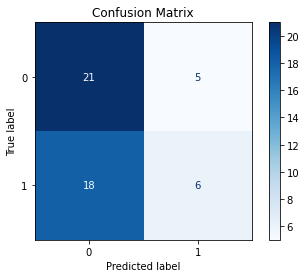

In [24]:
cm = confusion_matrix(y_true, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

**3. Select the False Negative patients obtained with the selected threshold in the
previous step**

In [25]:
df['y_pred_binary']=y_pred_binary

# False negatives y_pred=0 ; y_true=1
false_negatives = df[(df['Ground_truth'] == 1) & (df['y_pred_binary'] == 0)]

# Get the 'Patient_name' or 'Patient_ID' of the false negatives
patient_ids = false_negatives['Patient_name']

print(patient_ids.values)

['X13' 'D7' 'D20' 'X34' 'K32' 'K51' 'G12' 'E76' 'K7' 'X17' 'B27' 'K67'
 'E15' 'K3' 'X69' 'G121' 'G136' 'G116']


### Inspect misclassified images

**1. Compute the image histogram. You should see that two patients have something
weird in the histogram, identify them**

In [26]:
images_path='/Users/juliaromagosa/Downloads/imgs'
nifti_files = []
patient_names=[]
for root, dirs, files in os.walk(images_path):
    for file in files:
        if file.endswith('.nii.gz'):
            nifti_files.append(os.path.join(root, file))
            patient_names.append(file[:-7])

for file in nifti_files:
    print(file)

/Users/juliaromagosa/Downloads/imgs/X99.nii.gz
/Users/juliaromagosa/Downloads/imgs/K91.nii.gz
/Users/juliaromagosa/Downloads/imgs/G66.nii.gz
/Users/juliaromagosa/Downloads/imgs/E139.nii.gz
/Users/juliaromagosa/Downloads/imgs/G30.nii.gz


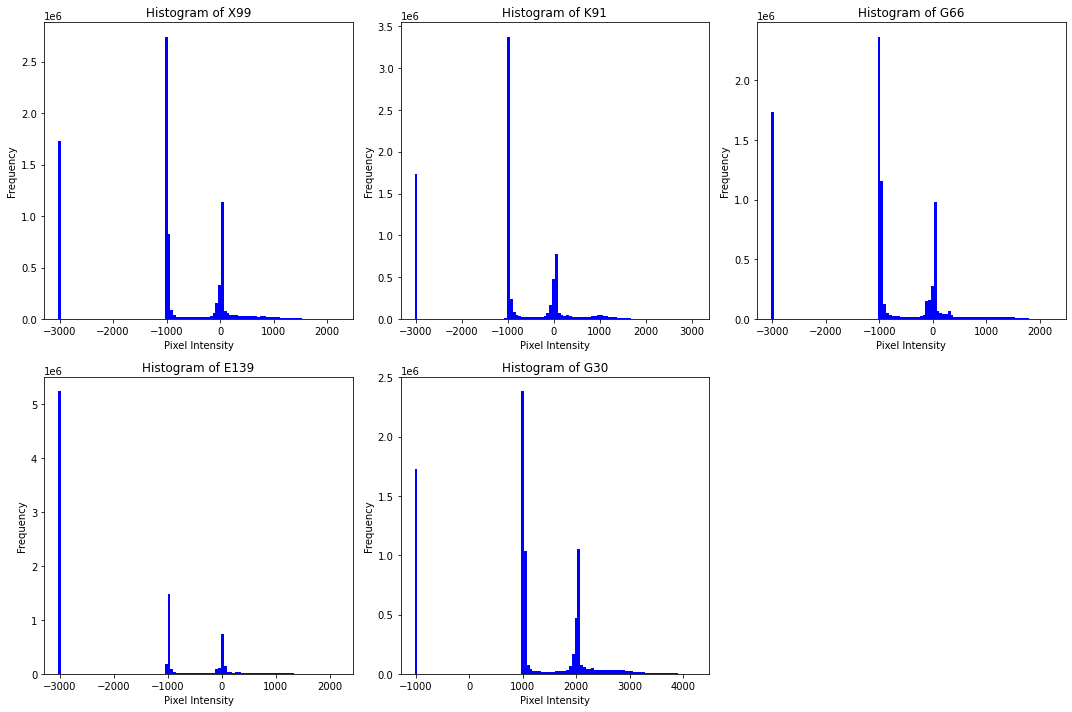

In [27]:
# Plot histograms
cols = 3  
rows = (len(nifti_files) + cols - 1) // cols  

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

axs = axs.ravel()

for i in range(len(nifti_files)):
    itk_image = sitk.ReadImage(nifti_files[i])
    image_array = sitk.GetArrayFromImage(itk_image)
    
    # Plot the histogram in the corresponding subplot
    axs[i].hist(image_array.ravel(), bins=100, color='blue')
    axs[i].set_title(f'Histogram of {patient_names[i]}')
    axs[i].set_xlabel('Pixel Intensity')
    axs[i].set_ylabel('Frequency')

# Remove unused subplots 
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Images with different histograms are:
- **E139:** it does have lower peak intensities compared to the others. It has a higer peak in intensity -3000, meaning there are more black pixels.
- **G30:** the intensity peaks are at different intensities compared to the others. It seems they are displaced by 1000.

First we'll plot the histogram of one of the "normal" images.

In [28]:
masks_path='/Users/juliaromagosa/Downloads/masks'
masks_files = []
for root, dirs, files in os.walk(masks_path):
    for file in files:
        if file.endswith('.nii.gz'):
            masks_files.append(os.path.join(root, file))

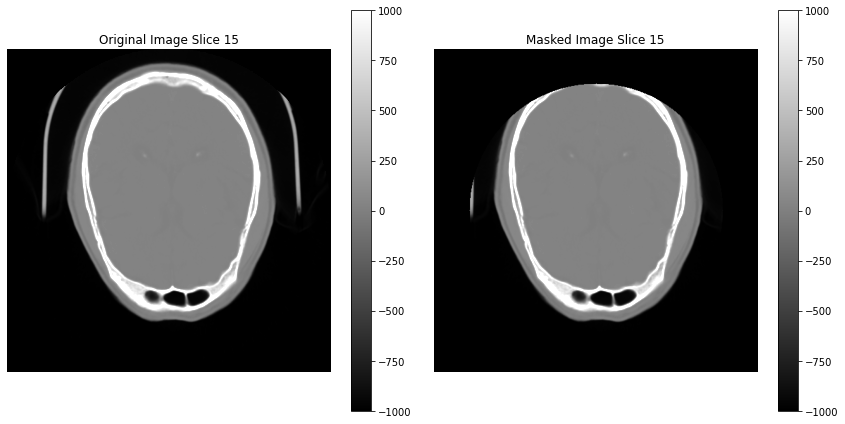

In [29]:
image_path = '/Users/juliaromagosa/Downloads/imgs/X99.nii.gz'
mask_path = '/Users/juliaromagosa/Downloads/masks/X99_mask.nii.gz'

# Read the images
image_array = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
mask_array = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
masked_image = np.where(mask_array == 0, -1000, image_array)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
slice_index=image_array.shape[0]//2

# Display the original image slice
im1 = axs[0].imshow(image_array[slice_index, :, :], cmap='gray',vmin=-1000,vmax=1000)
axs[0].set_title(f'Original Image Slice {slice_index}')
axs[0].axis('off')
plt.colorbar(im1, ax=axs[0])

# Display the masked image slice
im2 = axs[1].imshow(masked_image[slice_index, :, :], cmap='gray',vmin=-1000,vmax=1000)
axs[1].set_title(f'Masked Image Slice {slice_index}')
axs[1].axis('off')
plt.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()


The information is contained between -1000 and 1000, approximately.

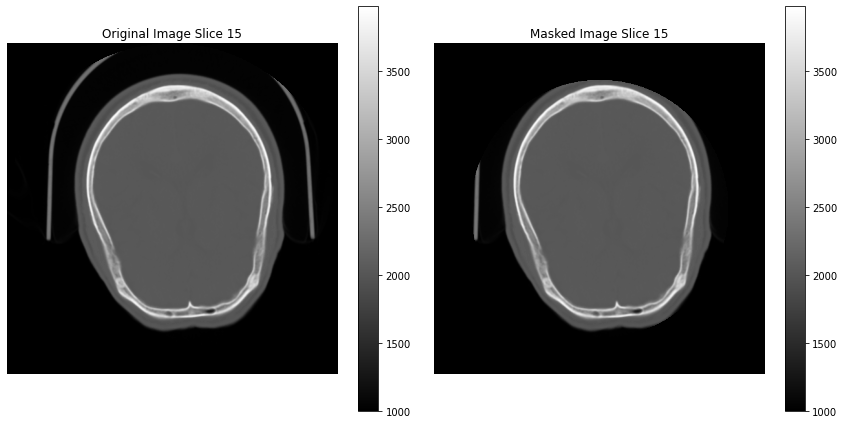

In [30]:
image_path = '/Users/juliaromagosa/Downloads/imgs/G30.nii.gz'
mask_path = '/Users/juliaromagosa/Downloads/masks/G30_mask.nii.gz'

# Read the images
image_array = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
mask_array = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
masked_image=image_array*mask_array

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
slice_index=image_array.shape[0]//2

# Display the original image slice
im1 = axs[0].imshow(image_array[slice_index, :, :], cmap='gray',vmin=1000)
axs[0].set_title(f'Original Image Slice {slice_index}')
axs[0].axis('off')
plt.colorbar(im1, ax=axs[0])

# Display the masked image slice
im2 = axs[1].imshow(masked_image[slice_index, :, :], cmap='gray',vmin=1000)
axs[1].set_title(f'Masked Image Slice {slice_index}')
axs[1].axis('off')
plt.colorbar(im2, ax=axs[1])

# Show the plots
plt.tight_layout()
plt.show()


In the G30 image, the pixels representing black have an intensity value of -1000, while in the other histograms, the black regions have an intensity of -3000. The background intensity in this image is 1000, with the relevant information lying between 1000 and 4000. Hence, the intensity range is different in this image and these discrepancies can lead the algorithm to fail. To address this, preprocessing normalizing techniques like histogram matching should be applied to ensure that all images have similar intensity distributions.

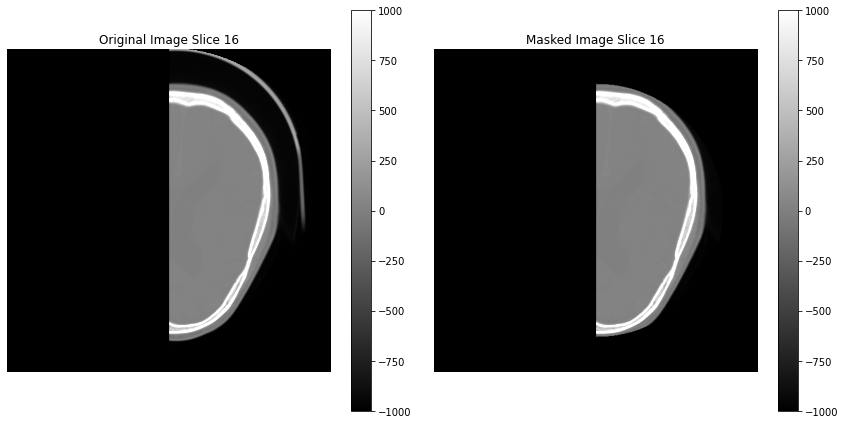

In [31]:
image_path = '/Users/juliaromagosa/Downloads/imgs/E139.nii.gz'
mask_path = '/Users/juliaromagosa/Downloads/masks/E139_mask.nii.gz'

# Read the images
image_array = sitk.GetArrayFromImage(sitk.ReadImage(image_path))
mask_array = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
masked_image = np.where(mask_array == 0, -1000, image_array)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
slice_index=image_array.shape[0]//2

# Display the original image slice
im1 = axs[0].imshow(image_array[slice_index, :, :], cmap='gray',vmin=-1000,vmax=1000)
axs[0].set_title(f'Original Image Slice {slice_index}')
axs[0].axis('off')
plt.colorbar(im1, ax=axs[0])

# Display the masked image slice
im2 = axs[1].imshow(masked_image[slice_index, :, :], cmap='gray',vmin=-1000,vmax=1000)
axs[1].set_title(f'Masked Image Slice {slice_index}')
axs[1].axis('off')
plt.colorbar(im2, ax=axs[1])

# Show the plots
plt.tight_layout()
plt.show()


In image E139, it is evident that the image has been sliced in half, which explains why the intensity peaks in the histogram are approximately half of those in the other images. It can be due to problems in image exportation or directly from the acquisition. Due to this issue, the image is not suitable for use and should be excluded from analysis.